
# How to build Trustworthy Model

AI-based systems are disrupting almost every industry and helping us to make crucial decisions that are impacting millions of lives.Hence it is extremely important to understand how these decisions are made by the AI system. There has been growing interest from researchers and practitioners to develop and deploy ML models and algorithms that are not only accurate, but also explainable, fair, bias free, secured, privacy-preserving, causal, and robust. 

#### This broad area of research is commonly referred to as trustworthy ML. 


# Lending Club Case Study with Explainable AI SHAPLey 

#### Background

Lending club is the largest peer-to-peer marketplace connecting borrowers with lenders.
Borrowers apply through an online platform where they are assigned an internal score. 
Lenders decide 1) whether to lend and 2) the terms of loan such as interest rate, monthly instalment, tenure etc.

#### Business Objective
 - To identify variables which are strong indicators of default 
 - Use the insights in approval / rejection decision making.

The data analysis is done for key features as focus is to create an Explaianable Model.
1. Data Loading
2. Data cleaning (cleaning missing values, removing redundant columns etc.) 
3. Data Preprocessing (Deriving new columns and process target variables)
4. Model Development 
5. Model Evaluation
5. Prediction
5. Apply SHAP explainer to explain the model prediction
6. Visualize the feature importance on model prediction via SHAP value plots
5. Recommendations

In [1]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import xgboost
from collections import Counter
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,roc_auc_score,classification_report
import pickle

import time
from sklearn.model_selection import GridSearchCV,KFold



from six import StringIO 
from IPython.display import Image   
from sklearn.tree import export_graphviz




In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

loan = pd.read_csv("loan.csv", sep=",")


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


## Data Understanding

In [5]:
# let's look at the first few rows of the df
loan.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,NaN,NaN,3,0,13648,83.70%,9,f,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.0,0.00,0.00,Jan-15,171.62,NaN,May-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0,Apr-99,5,NaN,NaN,3,0,1687,9.40%,4,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0,Nov-01,2,NaN,NaN,2,0,2956,98.50%,10,f,0.0,0.0,3005.666844,3005.67,2400.00,605.67,0.0,0.00,0.00,Jun-14,649.91,NaN,May-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [6]:
# Looking at all the column names
loan.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit'],
      dtype='object', length=111)

In [7]:
loan.shape

(39717, 111)

In [8]:
loan.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,3.971700e+04,3.971700e+04,39717.000000,39717.000000,39717.000000,39717.000000,3.971700e+04,39717.000000,39717.000000,39717.000000,14035.000000,2786.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39661.0,0.0,39717.0,0.0,0.0,0.0,39717.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39661.0,39717.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39020.000000,39678.0,0.0,0.0,0.0,0.0
mean,6.831319e+05,8.504636e+05,11219.443815,10947.713196,10397.448868,324.561922,6.896893e+04,13.315130,0.146512,0.869200,35.900962,69.698134,9.294408,0.055065,13382.528086,22.088828,51.227887,50.989768,12153.596544,11567.149118,9793.348813,2263.663172,1.363015,95.221624,12.406112,2678.826162,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043260,0.0,NaN,NaN,NaN,NaN
std,2.106941e+05,2.656783e+05,7456.670694,7187.238670,7128.450439,208.874874,6.379377e+04,6.678594,0.491812,1.070219,22.020060,43.822529,4.400282,0.237200,15885.016641,11.401709,375.172839,373.824457,9042.040766,8942.672613,7065.522127,2608.111964,7.289979,688.744771,148.671593,4447.136012,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.204324,0.0,NaN,NaN,NaN,NaN
min,5.473400e+04,7.069900e+04,500.000000,500.000000,0.000000,15.690000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN
25%,5.162210e+05,6.667800e+05,5500.000000,5400.000000,5000.000000,167.020000,4.040400e+04,8.170000,0.000000,0.000000,18.000000,22.000000,6.000000,0.000000,3703.000000,13.000000,0.000000,0.000000,5576.930000,5112.310000,4600.000000,662.180000,0.000000,0.000000,0.000000,218.680000,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

Some of the important columns in the dataset are loan_amount, term, interest rate, grade, sub grade, annual income, purpose of the loan etc.

The **target variable**, which we want to compare across the independent variables, is loan status. The strategy is to figure out compare the average default rates across various independent variables and identify the  ones that affect default rate the most.



# Data Cleaning

Some columns have a large number of missing values, let's first fix the missing values and then check for other types of data quality problems.

You can see that many columns have 100% missing values, some have 65%, 33% etc. First, let's get rid of the columns having 100% missing values.

In [9]:
# removing the columns having more than 90% missing values
missing_columns = loan.columns[100*(loan.isnull().sum()/len(loan.index)) > 0.5]
print(missing_columns)

Index(['emp_title', 'emp_length', 'desc', 'mths_since_last_delinq',
       'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
       'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m',
       'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il',
       'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc',
       'mths_since_recent_bc_dlq', 'mths_since_recent_inq',
       'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd',
       'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl',
       'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0',
       'nu

In [10]:
loan = loan.drop(missing_columns, axis=1)




In [11]:
# removing the columns having more than 90% missing values
missing_columns = loan.columns[100*(loan.isnull().sum()/len(loan.index)) > 0]
print(missing_columns)

Index(['title', 'revol_util', 'last_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'tax_liens'],
      dtype='object')


In [12]:
loan = loan.drop(missing_columns, axis=1)

In [13]:
# There are now 2 columns having approx 32 and 64% missing values - 
# description and months since last delinquent

# let's have a look at a few entries in the columns
#loan.loc[:, ['desc', 'mths_since_last_delinq']].head()

The column description contains the comments the applicant had written while applying for the loan. Although one can use some text analysis techniques to derive new features from this column (such as sentiment, number of positive/negative words etc.), we will not use this column in this analysis. 

Secondly, months since last delinquent represents the number months passed since the person last fell into the 90 DPD group. There is an important reason we shouldn't use this column in analysis - since at the time of loan application, we will not have this data (it gets generated months after the loan has been approved), it cannot be used as a predictor of default at the time of loan approval. 

Thus let's drop the two columns.

In [14]:
# dropping the two columns
#loan = loan.drop(['desc', 'mths_since_last_delinq'], axis=1)

In [15]:
# summarise number of missing values again
#100*(loan.isnull().sum()/len(loan.index))

There are some more columns with missing values, but let's ignore them for now (since we are ntot doing any modeling, we don't need to impute all missing values anyway). 

But let's check whether some rows have a large number of missing values.

In [16]:
# missing values in rows
#loan.isnull().sum(axis=1)

In [17]:
# checking whether some rows have more than 5 missing values
len(loan[loan.isnull().sum(axis=1) > 5].index)

0

The data looks clean by and large. Let's also check whether all columns are in the correct format.

In [18]:
# The column int_rate is character type, let's convert it to float
loan['int_rate'] = loan['int_rate'].apply(lambda x: pd.to_numeric(x.split("%")[0]))

In [19]:
# also, lets extract the numeric part from the variable employment length

# first, let's drop the missing values from the column (otherwise the regex code below throws error)
#loan = loan[~loan['emp_length'].isnull()]

# using regular expression to extract numeric values from the string
#import re
#loan['emp_length'] = loan['emp_length'].apply(lambda x: re.findall('\d+', str(x))[0])

# convert to numeric
#loan['emp_length'] = loan['emp_length'].apply(lambda x: pd.to_numeric(x))

## Data Analysis

Let's now move to data analysis. To start with, let's understand the objective of the analysis clearly and identify the variables that we want to consider for analysis. 

The objective is to identify predictors of default so that at the time of loan application, we can use those variables for approval/rejection of the loan. Now, there are broadly three types of variables - 1. those which are related to the applicant (demographic variables such as age, occupation, employment details etc.), 2. loan characteristics (amount of loan, interest rate, purpose of loan etc.) and 3. Customer behaviour variables (those which are generated after the loan is approved such as delinquent 2 years, revolving balance, next payment date etc.).

Now, the customer behaviour variables are not available at the time of loan application, and thus they cannot be used as predictors for credit approval. 

Thus, going forward, we will use only the other two types of variables.



In [20]:


behaviour_var =  [
  "delinq_2yrs",
  "earliest_cr_line",
  "inq_last_6mths",
  "open_acc",
  "pub_rec",
  "revol_bal",
  "total_acc",
  "out_prncp",
  "out_prncp_inv",
  "total_pymnt",
  "total_pymnt_inv",
  "total_rec_prncp",
  "total_rec_int",
  "total_rec_late_fee",
  "recoveries",
  "collection_recovery_fee",
  "last_pymnt_amnt",
  "application_type"]
behaviour_var

['delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'application_type']

In [21]:
# let's now remove the behaviour variables from analysis
df = loan.drop(behaviour_var, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   39717 non-null  int64  
 1   member_id            39717 non-null  int64  
 2   loan_amnt            39717 non-null  int64  
 3   funded_amnt          39717 non-null  int64  
 4   funded_amnt_inv      39717 non-null  float64
 5   term                 39717 non-null  object 
 6   int_rate             39717 non-null  float64
 7   installment          39717 non-null  float64
 8   grade                39717 non-null  object 
 9   sub_grade            39717 non-null  object 
 10  home_ownership       39717 non-null  object 
 11  annual_inc           39717 non-null  float64
 12  verification_status  39717 non-null  object 
 13  issue_d              39717 non-null  object 
 14  loan_status          39717 non-null  object 
 15  pymnt_plan           39717 non-null 

Typically, variables such as acc_now_delinquent, chargeoff within 12 months etc. (which are related to the applicant's past loans) are available from the credit bureau. 

In [22]:
# also, we will not be able to use the variables zip code, address, state etc.
# the variable 'title' is derived from the variable 'purpose'
# thus let get rid of all these variables as well

df = df.drop(['id', 'url', 'zip_code', 'addr_state'], axis=1)

Next, let's have a look at the target variable - loan_status. We need to relabel the values to a binary form - 0 or 1, 1 indicating that the person has defaulted and 0 otherwise.



In [23]:
df['loan_status'] = df['loan_status'].astype('category')
df['loan_status'].value_counts()

Fully Paid     32950
Charged Off     5627
Current         1140
Name: loan_status, dtype: int64

You can see that fully paid comprises most of the loans. The ones marked 'current' are neither fully paid not defaulted, so let's get rid of the current loans. Also, let's tag the other two values as 0 or 1. 

In [24]:
# filtering only fully paid or charged-off
df = df[df['loan_status'] != 'Current']
df['loan_status'] = df['loan_status'].apply(lambda x: 0 if x=='Fully Paid' else 1)

# converting loan_status to integer type
df['loan_status'] = df['loan_status'].apply(lambda x: pd.to_numeric(x))

# summarising the values
df['loan_status'].value_counts()

0    32950
1     5627
Name: loan_status, dtype: int64

Next, let's start with univariate analysis and then move to bivariate analysis.

## Univariate Analysis

First, let's look at the overall default rate.


In [25]:
# default rate
round(np.mean(df['loan_status']), 2)

0.15

The overall default rate is about 14%.  

Let's first visualise the average default rates across categorical variables.


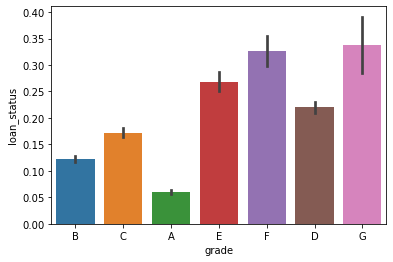

In [26]:
# plotting default rates across grade of the loan
sns.barplot(x='grade', y='loan_status', data=df)
plt.show()

In [27]:
# lets define a function to plot loan_status across categorical variables
def plot_cat(cat_var):
    sns.barplot(x=cat_var, y='loan_status', data=df)
    plt.show()
    

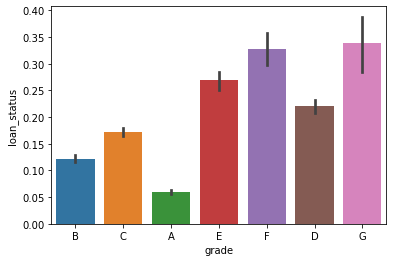

In [28]:
# compare default rates across grade of loan
plot_cat('grade')

Clearly, as the grade of loan goes from A to G, the default rate increases. This is expected because the grade is decided by Lending Club based on the riskiness of the loan. 

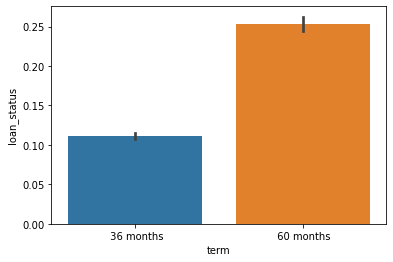

In [29]:
# term: 60 months loans default more than 36 months loans
plot_cat('term')

In [30]:
# sub-grade: as expected - A1 is better than A2 better than A3 and so on 
#plt.figure(figsize=(16, 6))
#plot_cat('sub_grade')

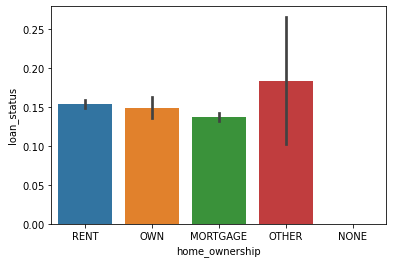

In [31]:
# home ownership: not a great discriminator
plot_cat('home_ownership')

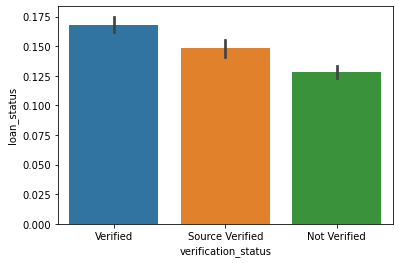

In [32]:
# verification_status: surprisingly, verified loans default more than not verifiedb
plot_cat('verification_status')

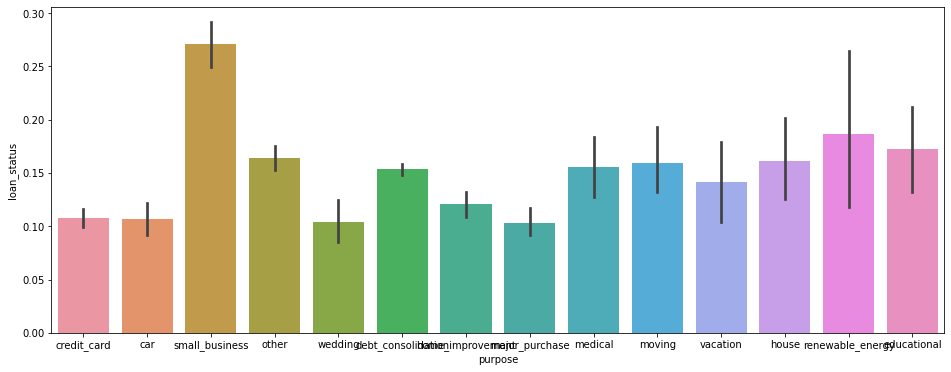

In [33]:
# purpose: small business loans defualt the most, then renewable energy and education
plt.figure(figsize=(16, 6))
plot_cat('purpose')

In [34]:
# let's also observe the distribution of loans across years
# first lets convert the year column into datetime and then extract year and month from it
df['issue_d'].head()

0    Dec-11
1    Dec-11
2    Dec-11
3    Dec-11
5    Dec-11
Name: issue_d, dtype: object

In [35]:
from datetime import datetime
df['issue_d'] = df['issue_d'].apply(lambda x: datetime.strptime(x, '%b-%y'))


In [36]:
# extracting month and year from issue_date
df['month'] = df['issue_d'].apply(lambda x: x.month)
df['year'] = df['issue_d'].apply(lambda x: x.year)




In [37]:
# let's first observe the number of loans granted across years
df.groupby('year').year.count()

year
2007      251
2008     1562
2009     4716
2010    11532
2011    20516
Name: year, dtype: int64

You can see that the number of loans has increased steadily across years. 

In [38]:
# number of loans across months
df.groupby('month').month.count()

month
1     2379
2     2358
3     2691
4     2831
5     2919
6     3180
7     3351
8     3388
9     3498
10    3761
11    4006
12    4215
Name: month, dtype: int64

Most loans are granted in December, and in general in the latter half of the year.

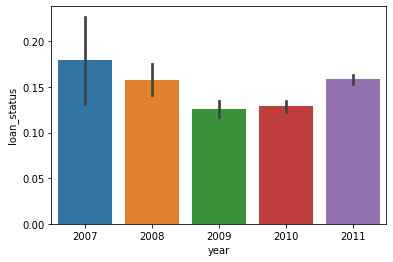

In [39]:
# lets compare the default rates across years
# the default rate had suddenly increased in 2011, inspite of reducing from 2008 till 2010
plot_cat('year')

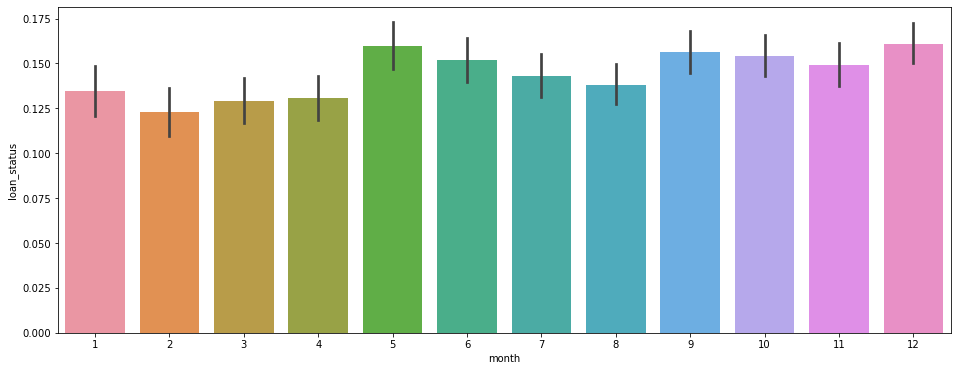

In [40]:
# comparing default rates across months: not much variation across months
plt.figure(figsize=(16, 6))
plot_cat('month')

Let's now analyse how the default rate varies across continuous variables.

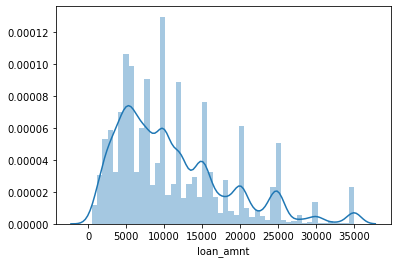

In [41]:
# loan amount: the median loan amount is around 10,000
sns.distplot(df['loan_amnt'])
plt.show()

The easiest way to analyse how default rates vary across continous variables is to bin the variables into discrete categories.

Let's bin the loan amount variable into small, medium, high, very high.

In [42]:
# debt to income ratio
def dti(n):
    if n <= 10:
        return 'low'
    elif n > 10 and n <=20:
        return 'medium'
    else:
        return 'high'
    

df['dti'] = df['dti'].apply(lambda x: dti(x))

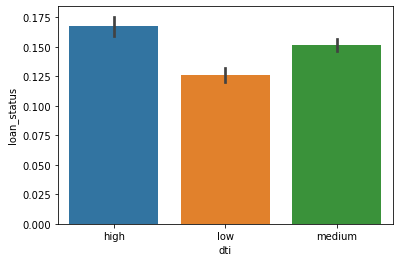

In [43]:
# comparing default rates across debt to income ratio
# high dti translates into higher default rates, as expected
plot_cat('dti')

In [44]:
# funded amount
def funded_amount(n):
    if n <= 5000:
        return 'low'
    elif n > 5000 and n <=15000:
        return 'medium'
    else:
        return 'high'
    
df['funded_amnt'] = df['funded_amnt'].apply(lambda x: funded_amount(x))

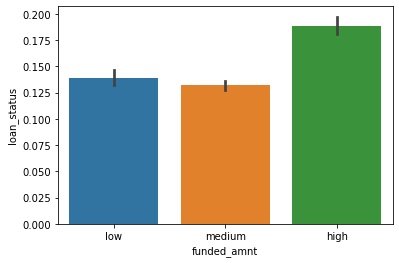

In [45]:
plot_cat('funded_amnt')


In [46]:
# employment length 
# first, let's drop the missing value observations in emp length
#df = df[~df['emp_length'].isnull()]

# binning the variable
#def emp_length(n):
#    if n <= 1:
#        return 'fresher'
#    elif n > 1 and n <=3:
#        return 'junior'
#    elif n > 3 and n <=7:
#        return 'senior'
#    else:
#        return 'expert'

#df['emp_length'] = df['emp_length'].apply(lambda x: emp_length(x))

In [47]:
# emp_length and default rate
# not much of a predictor of default
#plot_cat('emp_length')

## Segmented Univariate Analysis

We have now compared the default rates across various variables, and some of the important predictors are purpose of the loan, interest rate, annual income, grade etc.

In the credit industry, one of the most important factors affecting default is the purpose of the loan - home loans perform differently than credit cards, credit cards are very different from debt condolidation loans etc. 

This comes from business understanding, though let's again have a look at the default rates across the purpose of the loan.


In the upcoming analyses, we will segment the loan applications across the purpose of the loan, since that is a variable affecting many other variables - the type of applicant, interest rate, income, and finally the default rate. 

In general, debt consolidation loans have the highest default rates. Lets compare across other categories as well.

A good way to quantify th effect of a categorical variable on default rate is to see 'how much does the default rate vary across the categories'. 

Let's see an example using annual_inc as the categorical variable.

In [48]:
# filtering all the object type variables
df_categorical = df.loc[:, df.dtypes == object]
df_categorical['loan_status'] = df['loan_status']

# Now, for each variable, we can compute the incremental diff in default rates
print([i for i in df.columns])

['member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'purpose', 'dti', 'initial_list_status', 'policy_code', 'acc_now_delinq', 'delinq_amnt', 'month', 'year']


<ipython-input-48-b5c779058886>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_categorical['loan_status'] = df['loan_status']


In [49]:
df.columns

Index(['member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term',
       'int_rate', 'installment', 'grade', 'sub_grade', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'purpose', 'dti', 'initial_list_status', 'policy_code',
       'acc_now_delinq', 'delinq_amnt', 'month', 'year'],
      dtype='object')

In [50]:
#!pip install xgboost

In [51]:
# store columns with specific data type
numeric_columns = df.select_dtypes(include=['integer', 'float64', 'uint8']).columns

categorical_columns = df.select_dtypes(include=['object']).columns

print("numeric_columns: ", numeric_columns)
print("categorical_columns :", categorical_columns)

numeric_columns:  Index(['member_id', 'loan_amnt', 'funded_amnt_inv', 'int_rate', 'installment',
       'annual_inc', 'loan_status', 'policy_code', 'acc_now_delinq',
       'delinq_amnt', 'month', 'year'],
      dtype='object')
categorical_columns : Index(['funded_amnt', 'term', 'grade', 'sub_grade', 'home_ownership',
       'verification_status', 'pymnt_plan', 'purpose', 'dti',
       'initial_list_status'],
      dtype='object')


In [52]:
df[categorical_columns ].shape

(38577, 10)

In [53]:
# convert into dummies - one hot encoding
df_dummy = pd.get_dummies(df[categorical_columns ], drop_first=True)
df_dummy.head()

,funded_amnt_low,funded_amnt_medium,term_ 60 months,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,dti_low,dti_medium
0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
5,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


In [54]:
# drop categorical variables from numeric dataset
df_tmp = df.drop(categorical_columns, axis=1)

In [55]:
df_tmp.isnull().sum()

member_id          0
loan_amnt          0
funded_amnt_inv    0
int_rate           0
installment        0
annual_inc         0
issue_d            0
loan_status        0
policy_code        0
acc_now_delinq     0
delinq_amnt        0
month              0
year               0
dtype: int64

In [56]:
# concat dummy variables with categorical dataset
df_train = pd.concat([df_tmp, df_dummy], axis=1)

In [57]:
# store columns with specific data type
numeric_columns = df_train.select_dtypes(include=['integer', 'float64', 'uint8']).columns

categorical_columns = df_train.select_dtypes(include=['object']).columns

print("numeric_columns: ", numeric_columns)
print("categorical_columns :", categorical_columns)

numeric_columns:  Index(['member_id', 'loan_amnt', 'funded_amnt_inv', 'int_rate', 'installment',
       'annual_inc', 'loan_status', 'policy_code', 'acc_now_delinq',
       'delinq_amnt', 'month', 'year', 'funded_amnt_low', 'funded_amnt_medium',
       'term_ 60 months', 'grade_B', 'grade_C', 'grade_D', 'grade_E',
       'grade_F', 'grade_G', 'sub_grade_A2', 'sub_grade_A3', 'sub_grade_A4',
       'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2', 'sub_grade_B3',
       'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1', 'sub_grade_C2',
       'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5', 'sub_grade_D1',
       'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4', 'sub_grade_D5',
       'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3', 'sub_grade_E4',
       'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2', 'sub_grade_F3',
       'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1', 'sub_grade_G2',
       'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5', 'home_ownership_NONE',
       'home_ownership_OTHER', '

In [58]:
# removing the columns having more than 90% missing values
missing_columns = df_train.columns[100*(df_train.isnull().sum()/len(df_train.index)) > 0]
print(missing_columns)


Index([], dtype='object')


In [59]:
df_train.drop(missing_columns, axis =1, inplace = True)

In [60]:
# removing the columns having more than 90% missing values
missing_columns = df_train.columns[100*(df_train.isnull().sum()/len(df_train.index)) > 0]
print(missing_columns)

Index([], dtype='object')


In [61]:
df_train.drop(['issue_d'], axis =1, inplace=True)

In [62]:
df_train.head(2)


,member_id,loan_amnt,funded_amnt_inv,int_rate,installment,annual_inc,loan_status,policy_code,acc_now_delinq,delinq_amnt,month,year,funded_amnt_low,funded_amnt_medium,term_ 60 months,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,dti_low,dti_medium
0,1296599,5000,4975.0,10.65,162.87,24000.0,0,1,0,0,12,2011,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1314167,2500,2500.0,15.27,59.83,30000.0,1,1,0,0,12,2011,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### Preparing Training Data

In [63]:
#print(df_train.head(2))
df_train=df_train.set_index('member_id')



In [64]:
 #Preparing X dataset for training
X = df_train.drop(['loan_status'],axis=1)

#Putting response variable to y
y = df_train['loan_status']


In [65]:
df_train['loan_status'].value_counts()

0    32950
1     5627
Name: loan_status, dtype: int64

In [66]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

In [67]:
print(X_train.shape)
print(y_train.shape)

(27003, 74)
(27003,)


In [68]:
#!pip install shap
import shap


In [69]:

#logreg = LogisticRegression(solver='lbfgs', max_iter=100)
#rfe = RFE(logreg, 15)             # running RFE with 20 variables as output

#rfe = rfe.fit(X_train,y_train)
#print(rfe.support_)           # Printing the boolean results
#print(rfe.ranking_)           # Printing the ranking

In [70]:
# Variables selected by RFE 
#list(zip(X_train.columns,rfe.support_,rfe.ranking_))

#col = X.columns[rfe.support_]
#col

In [71]:
# train XGBoost model

#model = xgboost.XGBClassifier(n_estimators=100, max_depth=2).fit(X_train[col],y_train)

model = xgboost.XGBClassifier(n_estimators=100, max_depth=2).fit(X_train,y_train)


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[21:52:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [72]:
model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 2,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

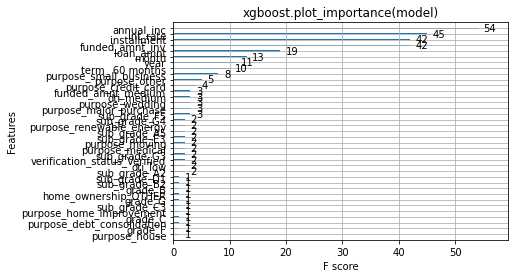

In [73]:
import matplotlib.pylab as pl
xgboost.plot_importance(model)
pl.title("xgboost.plot_importance(model)")
pl.show()

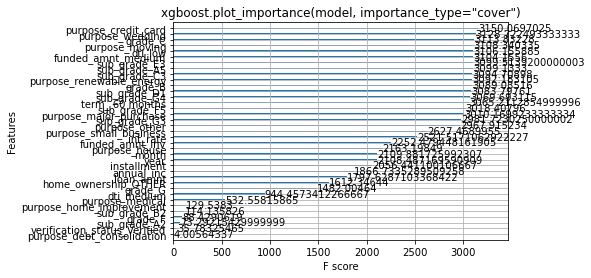

In [74]:
xgboost.plot_importance(model, importance_type="cover")
pl.title('xgboost.plot_importance(model, importance_type="cover")')
pl.show()

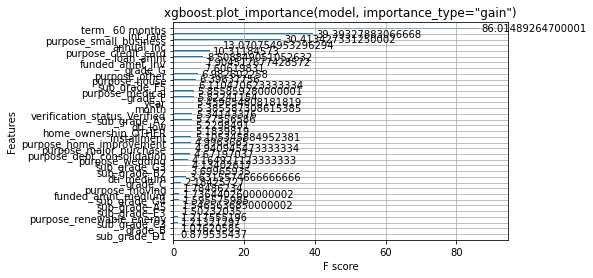

In [75]:
xgboost.plot_importance(model, importance_type="gain")
pl.title('xgboost.plot_importance(model, importance_type="gain")')
pl.show()

In [76]:

# Get our predictions
#xgb_predictions = model.predict(X_test[col])
xgb_predictions = model.predict(X_test)

In [79]:
#xgb_predictions_prob = model.predict_proba(X_test[col])
xgb_predictions_prob = model.predict_proba(X_test)
xgb_predictions_prob

array([[0.83609504, 0.16390498],
       [0.87653005, 0.12346993],
       [0.92666626, 0.07333377],
       ...,
       [0.94052476, 0.05947522],
       [0.83576286, 0.16423717],
       [0.850453  , 0.149547  ]], dtype=float32)

In [80]:
print(accuracy_score(y_test, xgb_predictions))
# Predicted probabilities
#y_pred_xgb = model.predict(X_test[col])
y_pred_xgb = model.predict(X_test)

# Converting y_pred to a dataframe which is an array
y_pred_df_xgb = pd.DataFrame(y_pred_xgb)

print(y_pred_df_xgb[0].value_counts())

0.8537238638327286
0    11493
1       81
Name: 0, dtype: int64


In [81]:
# Converting y_test to dataframe
y_test_df_xgb = pd.DataFrame(y_test)
#print(y_test_df_xgb.head(10))
#print(y_test_df_xgb.info())

#print(y_test_df_xgb['loan_status'].value_counts())

In [82]:
print(y_test_df_xgb['loan_status'].value_counts())
#print(y_pred_df_xgb)

0    9876
1    1698
Name: loan_status, dtype: int64


In [83]:
y_test_df_xgb.reset_index(inplace=True)


print(y_test_df_xgb.head(2))

   member_id  loan_status
0     349026            0
1    1050063            0


In [84]:
y_pred_final_xgb = pd.concat([y_pred_df_xgb,y_test_df_xgb],axis=1)

In [85]:
#y_pred_final_xgb.head(10)

In [86]:
# Rearranging the columns

y_pred_final_xgb= y_pred_final_xgb.rename(columns={ 0 : 'predicted_xgb'})
y_pred_final_xgb.head(2)

,predicted_xgb,member_id,loan_status
0,0,349026,0
1,0,1050063,0


In [87]:
print(classification_report(y_pred_final_xgb.loan_status, y_pred_final_xgb.predicted_xgb))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92      9876
           1       0.53      0.03      0.05      1698

    accuracy                           0.85     11574
   macro avg       0.69      0.51      0.48     11574
weighted avg       0.81      0.85      0.79     11574



# Explain Model prediction with Shapley 

#### Here we demonstrate how to use SHAP values to understand XGBoost model predictions.

Although output contains all the information required to explain the machine learning model's prediction, looking at long lists of numbers isn't especially helpful. 

We provide a number of visualization that clearly show which features increase and decrease the risk of loan default for an individual loan application. This is called Local feature Importance.

Global feature importance plot created by passing a matrix of SHAP values to the bar plot function. The global importance of each feature is taken to be the mean absolute value for that feature over all the given samples


In [88]:
# compute the SHAP values for the linear model
#background_fraud = shap.maskers.Independent(X_train[col], max_samples=100)
background_fraud = shap.maskers.Independent(X_train, max_samples=100)

# compute SHAP values
explainer = shap.Explainer(model, background_fraud)
#shap_values = explainer(X_train[col], check_additivity=False)
shap_values = explainer(X_train, check_additivity=False)

 99%|===================| 26867/27003 [00:33<00:00]        

In [89]:
#shap_values = explainer(X_test[col], check_additivity=False)
shap_values = explainer(X_test, check_additivity=False)

 97%|=================== | 11180/11574 [00:14<00:00]       

### Global feature importance :  

The global feature importance plot created by passing a matrix of SHAP values to the bar plot function. The global importance of each feature is taken to be the mean absolute value for that feature over all the given samples.
By default, the bar plot only shows a maximum of ten bars, but we can use the max_display parameter to control these numbers.


The X-axis is showing the absolute mean of SHAP values. Features are plotted on the y axis in ascending order of their feature importance.

The number written on the right side of each bar plot is the respective mean shap values of the feature which is the effect of that feature on the loan default prediction


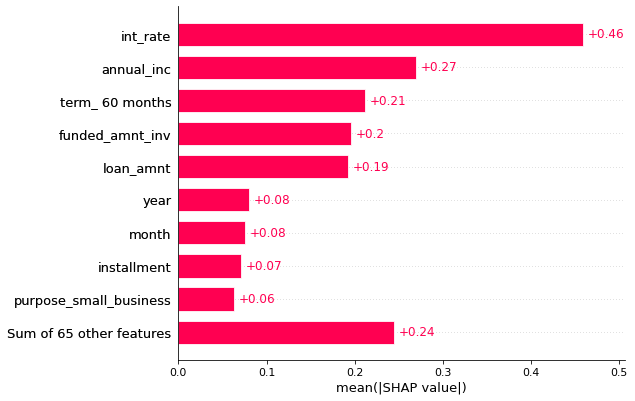

In [90]:
shap.plots.bar(shap_values) 

### SHAP Summary plot

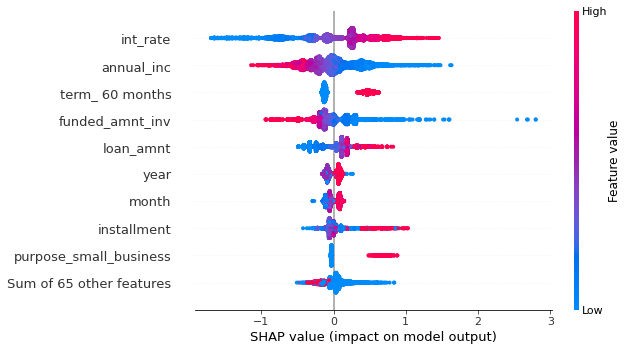

In [91]:
shap.plots.beeswarm(shap_values)

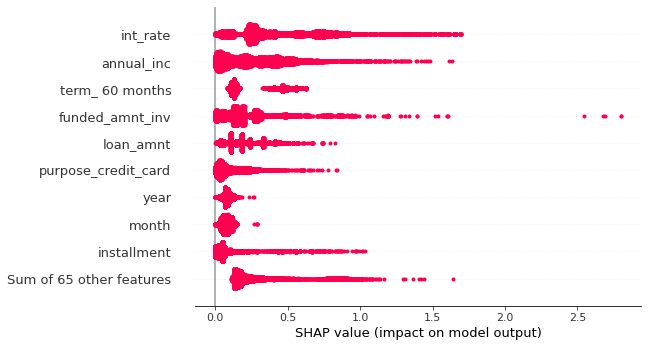

In [92]:
shap.plots.beeswarm(shap_values.abs, color="shap_red")

#### Dependence plot or Interaction plot:

This is shown with shap.plots.scatter() function with the feature as a parameter and the color value is set to shap_values. The function automatically includes another variable that the selected feature interacts most with.

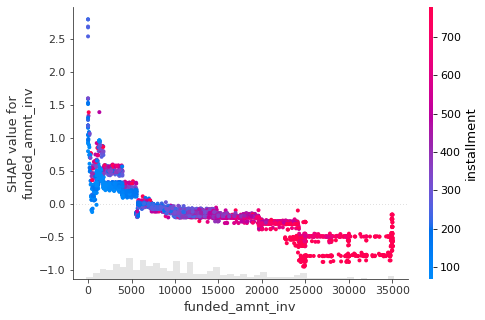

In [93]:
shap.plots.scatter(shap_values[:,"funded_amnt_inv"], color=shap_values)

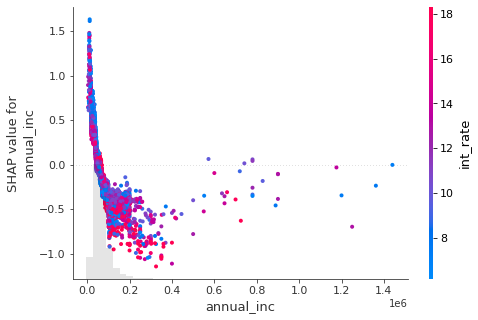

In [94]:
shap.plots.scatter(shap_values[:,"annual_inc"], color=shap_values)

### Local feature importance : The waterfall_plot shows below how we get from explainer.expected_value to model.predict(X) for the sample_indicator


 - A waterfall chart can be used to show the cumulative effect of each feature. Starting with the baseline probability for loan defaults (at the bottom of the chart), we can see how each additional feature shifts the probability. After all features have been considered, we reach the final predicted loan default risk (at the top of the chart).

#### The explanation shows the features each contributing to push the model output from the base value to the model output.
Base value -> The average model value over the training dataset 

 - Features in Red are pushing the prediction higher than the base value which means to increase the probability of "default"

 - Features in Blue are pushing the prediction lower than the base value which means to dncrease the probability of "default"
 




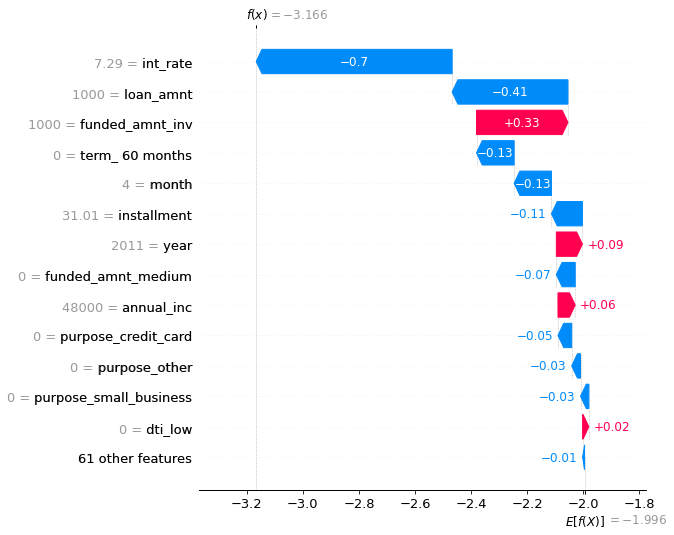

In [100]:
# Explain the specific Sample
sample_ind = 9
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

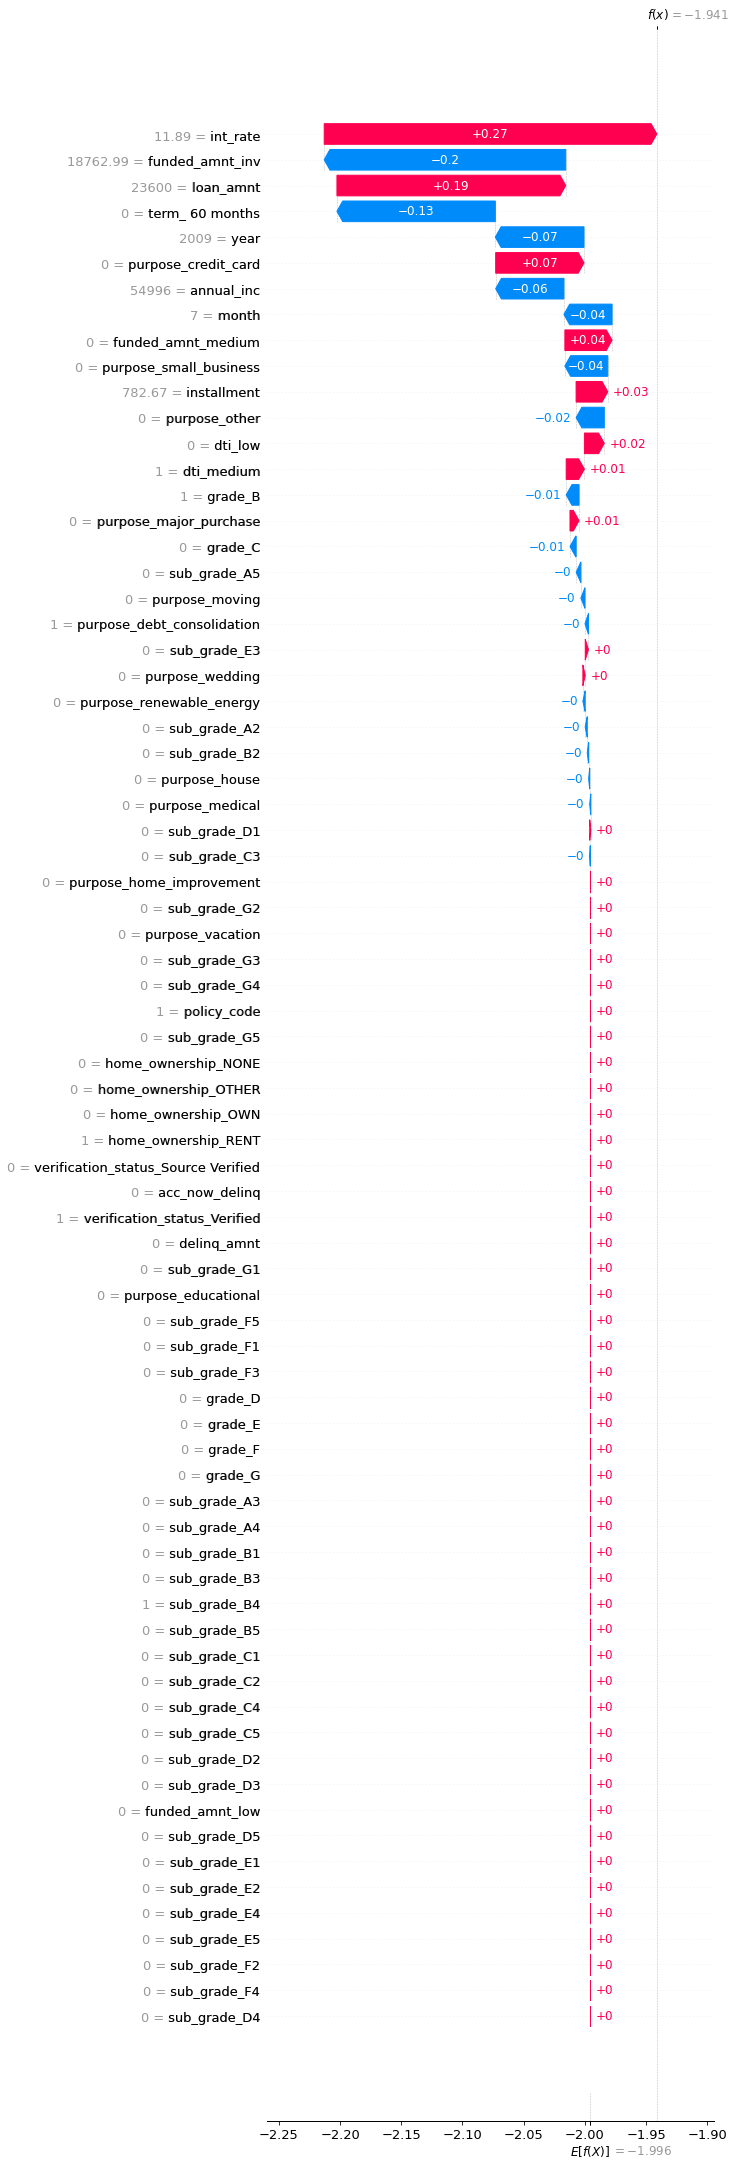

In [101]:
# Explain the specific  Sample "sample_ind"
sample_ind = 1000
shap.plots.waterfall(shap_values[sample_ind], max_display=1000)

### SHAP local feature importance with bar plot

 - The Red colour in the above plot explains that the high value of the feature will increase the probablity of Label=1 which is default loan in this case.
 - The Blue colour in the above plot explains that the low value of the feature will decrease the probablity of Label=1 which is default loan in this case.

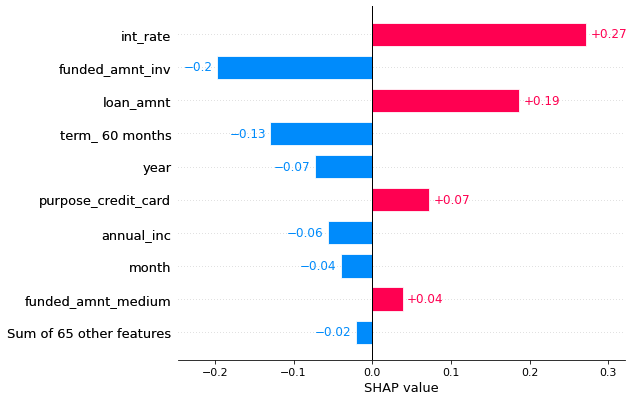

In [102]:
# Explain the 1000th Sample with other plots
shap.plots.bar(shap_values[1000])

### SHAP Local feature importance with heatmap

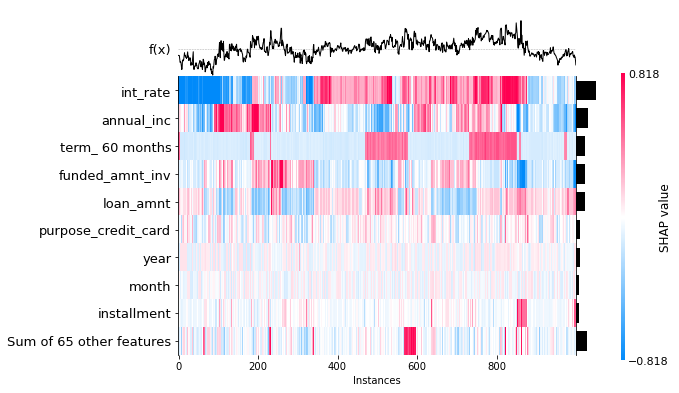

In [103]:
# Explain the 1000th Sample with other plots - Heatmap
shap.plots.heatmap(shap_values[:1000])

### SHAP Local feature importance : Visualize the specific prediction's explanation with a force plot

#### Force plot
 - Base value is the threshold. Anything which is above base value is denoting the label 1
 - Below base value is denoting the label 0
 - Direction is showing Importance of every feature that is driving it above or below the base value.
 - Red features are trying to push the prediction values above the base value indicating high risk of default loan
 - Blue features are trying to push the prediction below the base value indicating low risk of default loan
 


In [104]:
# visualize the first prediction's explanation with a force plot. 
#This plot is mot visible in github. run this code in notebook to generate the plots

shap.initjs()
shap.plots.force(shap_values[0])

In [105]:
# visualize the first prediction's explanation with a force plot
shap.initjs()
shap.plots.force(shap_values[2000])

### Conclusion

#### Model 
 - Could classify the loan applications and predict whether the loan would be payed back or not
 - Could explain specific failure cases in model predictions
 - Explained risk factor for loan default
 - Achieved the stakeholder's trust in model
 - Could identify potential bias in model 
 - Comply with “right for explanation” for users
 - Helped Bank to Reduce the risk of losing money due to unpaid loans
 - Also reduce the risk of denying trustworthy customers loans which has a set of negative impacts.
